# GIA - Práctica 2
## Segmentación

El objetivo de esta práctica es el desarrollo de una metodología para la segmentación automática de las regiones de fluido patológico en imágenes OCT.


In [1]:
# Connect to drive

from google.colab import drive
import os

drive.mount('/content/gdrive')

route = '/content/gdrive/MyDrive/GIA/VCA/P2/'

print('\nChange the directory to project route')
%cd $route

Mounted at /content/gdrive

Change the directory to project route
/content/gdrive/MyDrive/GIA/VCA/P2


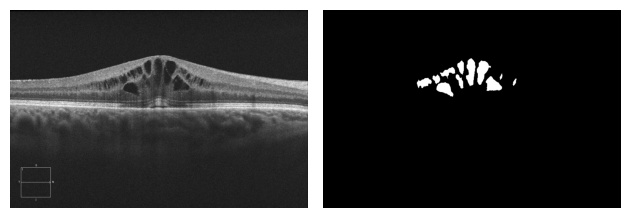

In [2]:
import matplotlib.pyplot as plt

# Aux function that shows an image and its corresponding mask in the same figure
def show(image, mask, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

im = plt.imread(f"{route}OCT-dataset/images/sample_01.jpg")
mask = plt.imread(f"{route}OCT-dataset/masks/sample_01.jpg")
show(im, mask)

**Sugerencia**: Para el cálculo de métricas de rendimiento se puede utilizar la siguiente función auxiliar que permite obtener la máscara de segmentación a partir de las salidas de la red. La salida de la red es un valor positivo en coma flotante. La función sigmoidea restringe el dominio de salida entre 0 y 1. Como la máscara de salida es binaria, usamos un umbral para establecer los valores de la máscara de salida en 0 ó 1. Ten en cuenta que tal vez tengas que ajustar el umbral por defecto.

In [3]:
# Aux function to get binary segmentation mask
import torch
def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold) * 1.0
    return masks

# Aux function to show results
def show_result(orig, gt, prediction, title=None):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    ax = axes.ravel()

    images = [orig, gt, prediction, orig*prediction]
    titles = ['Orig', 'Gt', 'Result', 'Overlap']
    for i, (im, tit) in enumerate(zip(images, titles)):
        ax[i].imshow(im, cmap='gray')
        ax[i].set_title(tit)
        ax[i].axis('off')
    plt.show()

## UNet
UNet es una red convolucional diseñada para la segmentación de imágenes biomédicas. Sus tasas de éxito son altas incluso con pocas imágenes en el conjunto de entrenamiento.
En esta práctica abordaremos la tarea de segmentación usando una UNet. Los pasos generales a seguir son los siguientes:
1. Definir la arquitectura de red
2. Creación de dataset
   - Generar conjuntos de entrenamiento, validación y test
3. Entrenar la red
4. Seleccionar modelo en base a conjunto de validación
5. Test del modelo seleccionado

### Paso 1: Arquitectura de red

Puedes implementar la red desde cero a partir de la descripción proporcionada en el [paper original](https://arxiv.org/abs/1505.04597), utilizar algún paquete de python que proporciona la implementación y modelos preentrenados como [Segmentation Models based on PyTorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/) o utilizar el código fuente disponible online de alguna de las arquitecturas de red típicas. Por ejemplo, la siguiente implementación adaptada [de este código fuente](https://github.com/usuyama/pytorch-unet).

In [4]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

### Paso 2: Creación de Dataset
En este paso, vamos a cargar los datos extendiendo la clase `Dataset` de torch.

Dado que el número de ejemplos en nuestro conjunto de datos es pequeño, podemos aplicar algunas transformaciones (rotaciones, traslaciones, suavizado, ...) para generar muestras artificiales y, de esta manera, aumentar el número de muestras en nuestro conjunto de datos. Esto se denomina aumento de datos. Puedes encontrar más información sobre el aumento de datos y su implementación en las [páginas de documentación de PyTorch](https://pytorch.org/vision/stable/transforms.html).

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random
import cv2

class OCTDataset(Dataset):

    def __init__(self, image_path, mask_path, rsize = (416,624), transform = None):
        super().__init__()
        # Load all the filenames with extension tif from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path,'*.jpg'))

        self.mask_files = []

        # We asume that each image has the same filename as its corresponding mask
        # but it is stored in another directory (mask_path)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path, os.path.basename(img_path)))

        self.rsize = rsize  # Size to use in default Resize transform
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = plt.imread(img_path)
        mask = plt.imread(mask_path)
        if len(mask.shape) > 2:
            mask = mask[:,:,0]
        if len(image.shape) > 2:
            image = image[:,:,0]
        _, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY) # Make sure that mask is binary
        # Apply the defined transformations to both image and mask
        if self.transform is not None:
            seed = np.random.randint(2147483647) # make a seed with numpy generator
            random.seed(seed) # apply this seed to image transforms
            torch.manual_seed(seed)
            image = self.transform(image)
            random.seed(seed) # apply the same seed to mask transforms
            torch.manual_seed(seed)
            mask = self.transform(mask)
        else:
            t = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(self.rsize, interpolation= InterpolationMode.NEAREST),
                transforms.ToTensor()])

            image = t(image)
            mask = t(mask)

        return image, mask

    def __len__(self):
        return len(self.img_files)

Dataset len: 50


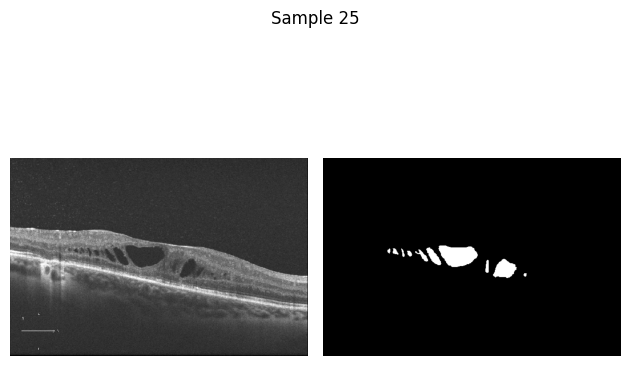

In [6]:
# Load some samples
simple_dataset = OCTDataset(f"{route}/OCT-dataset/images", f"{route}/OCT-dataset/masks")
print("Dataset len:", len(simple_dataset))
nsamples = 1
for _ in range(nsamples):
    idx = np.random.randint(0, len(simple_dataset))
    im, mask = simple_dataset[idx]
    show(im.squeeze(), mask.squeeze(), title=f"Sample {idx}")

## **Hasta aquí viene dado**

### Partición del dataset en entrenamiento/validación

In [7]:
from sklearn.model_selection import train_test_split
import glob
import os

image_path = "OCT-dataset/images"
mask_path = "OCT-dataset/masks"

all_images = glob.glob(os.path.join(image_path, '*.jpg'))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Número de imágenes de entrenamiento: {len(train_imgs)}")
print(f"Número de imágenes de validación: {len(val_imgs)}")

Número de imágenes de entrenamiento: 40
Número de imágenes de validación: 10


### Creación de los Dataset y DataLoader para cada partición

In [8]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# Transformación base para imágenes y máscaras (solo resize y tensorización)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 624), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Dataset modificado para usar solo las imágenes de cada split
class OCTSubsetDataset(OCTDataset):
    def __init__(self, img_list, image_path, mask_path, transform=None):
        self.img_files = img_list
        self.mask_files = [os.path.join(mask_path, os.path.basename(p)) for p in img_list]
        self.rsize = (416, 624)
        self.transform = transform

train_dataset = OCTSubsetDataset(train_imgs, image_path, mask_path, transform=transform)
val_dataset = OCTSubsetDataset(val_imgs, image_path, mask_path, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


### Entrenamiento de nuestro modelo UNet

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet(input_channels=1, n_class=1).to(device)  # Output 1 canal para máscara binaria

# Binary Cross Entropy con logits (más estable)
pos_weight = torch.tensor([60.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Device: cuda:0


In [10]:
num_epochs = 50 # TODO: cambiar
best_val_loss = float('inf')
model_path = "best_unet_model.pth"

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluación en validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)

    epoch_time = round(time.time() - start_time, 2)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time}")

    # Guardar el mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        print("  ↳ Modelo guardado (el mejor hasta ahora)")

Epoch [1/50] | Train Loss: 1.3359 | Val Loss: 1.2716 | Time: 43.6
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [2/50] | Train Loss: 1.3350 | Val Loss: 1.2703 | Time: 9.99
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [3/50] | Train Loss: 1.3340 | Val Loss: 1.2689 | Time: 10.94
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [4/50] | Train Loss: 1.3327 | Val Loss: 1.2666 | Time: 10.59
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [5/50] | Train Loss: 1.3306 | Val Loss: 1.2638 | Time: 11.49
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [6/50] | Train Loss: 1.3278 | Val Loss: 1.2572 | Time: 11.52
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [7/50] | Train Loss: 1.3165 | Val Loss: 1.2391 | Time: 11.57
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [8/50] | Train Loss: 1.2606 | Val Loss: 1.1359 | Time: 10.34
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [9/50] | Train Loss: 1.1103 | Val Loss: 1.0994 | Time: 10.2
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [10/50]

In [14]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, jaccard_score
import numpy as np
import matplotlib.pyplot as plt

# Función auxiliar para binarizar predicciones
def get_binary_mask(output, threshold=0.5):
    return (torch.sigmoid(output) > threshold).float()

# Cargar mejor modelo
model.load_state_dict(torch.load(model_path))
model.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = get_binary_mask(outputs, threshold=thresh)

            # Flatten para calcular métricas
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    # Convertir a arrays
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    # Cálculo de métricas por pixel
    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = ((precision * recall)/(precision + recall))

    print(f"IoU: {iou:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")

    results[i] = [thresh, iou, acc, precision, recall, f1]

IoU: 0.0891
Accuracy: 0.8557
Precision: 0.0891
Recall: 0.9977
F1 score: 0.0818
IoU: 0.1077
Accuracy: 0.8832
Precision: 0.1077
Recall: 0.9955
F1 score: 0.0972
IoU: 0.1212
Accuracy: 0.8980
Precision: 0.1213
Recall: 0.9934
F1 score: 0.1081
IoU: 0.1334
Accuracy: 0.9089
Precision: 0.1336
Recall: 0.9904
F1 score: 0.1177
IoU: 0.1438
Accuracy: 0.9168
Precision: 0.1441
Recall: 0.9873
F1 score: 0.1257
IoU: 0.1553
Accuracy: 0.9242
Precision: 0.1557
Recall: 0.9842
F1 score: 0.1344
IoU: 0.1669
Accuracy: 0.9307
Precision: 0.1675
Recall: 0.9810
F1 score: 0.1431
IoU: 0.2000
Accuracy: 0.9447
Precision: 0.2009
Recall: 0.9774
F1 score: 0.1666
IoU: 0.2713
Accuracy: 0.9630
Precision: 0.2733
Recall: 0.9732
F1 score: 0.2134
IoU: 0.3423
Accuracy: 0.9737
Precision: 0.3461
Recall: 0.9686
F1 score: 0.2550
IoU: 0.3758
Accuracy: 0.9774
Precision: 0.3814
Recall: 0.9622
F1 score: 0.2732
IoU: 0.3995
Accuracy: 0.9797
Precision: 0.4071
Recall: 0.9557
F1 score: 0.2855
IoU: 0.4200
Accuracy: 0.9815
Precision: 0.4303
Recal

In [12]:
iou_results  = results[:, 1]
acc_results  = results[:, 2]
prec_results = results[:, 3]
rec_results  = results[:, 4]
f1_results   = results[:, 5]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, iou_results, label="IoU")
plt.plot(thresholds, acc_results, label="Accuracy")
plt.plot(thresholds, prec_results, label="Precision")
plt.plot(thresholds, rec_results, label="Recall")
plt.plot(thresholds, f1_results, label="F1-Score")
plt.legend(loc="center left")
plt.title("Métricas con diferentes umbrales")
plt.xticks(thresholds)
plt.ylabel("Valor métrica")
plt.xlabel("Umbral")
plt.show()

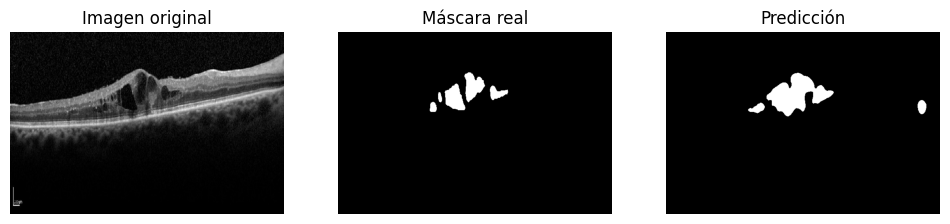

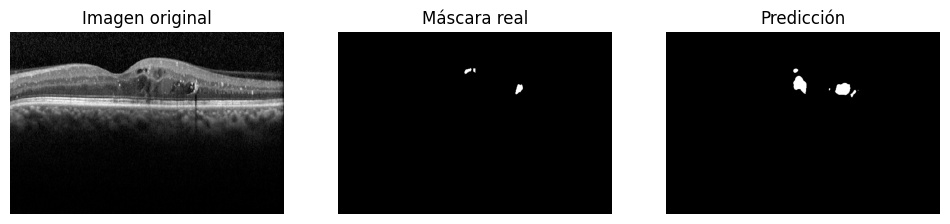

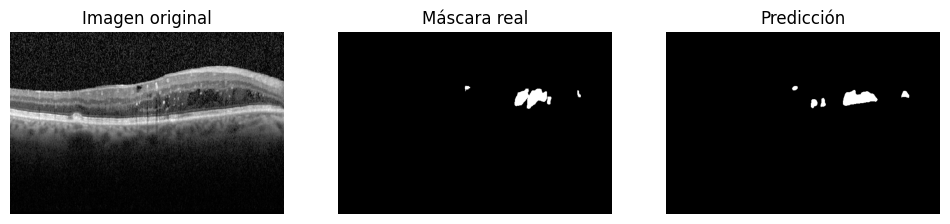

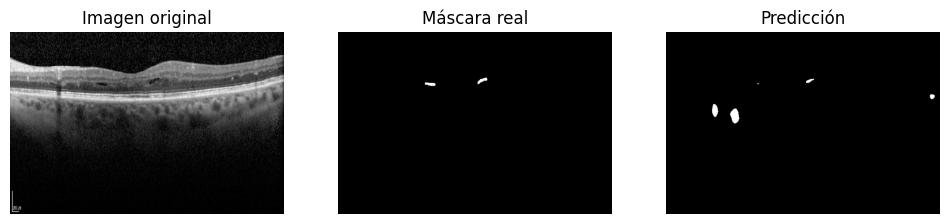

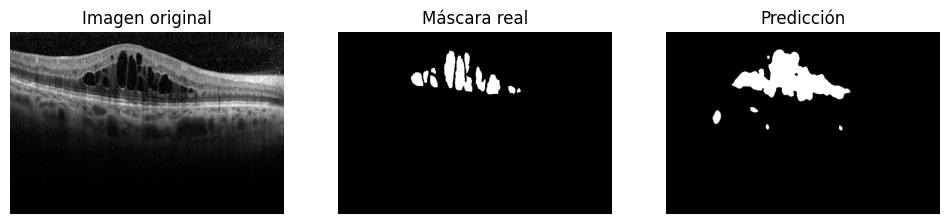

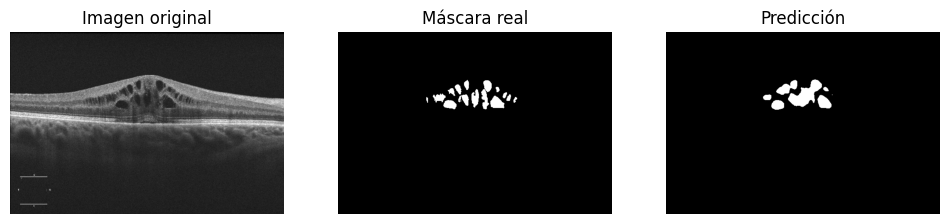

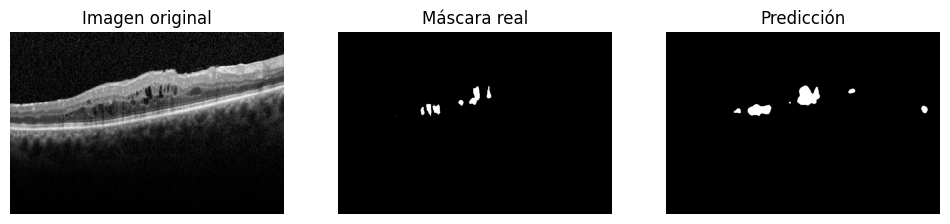

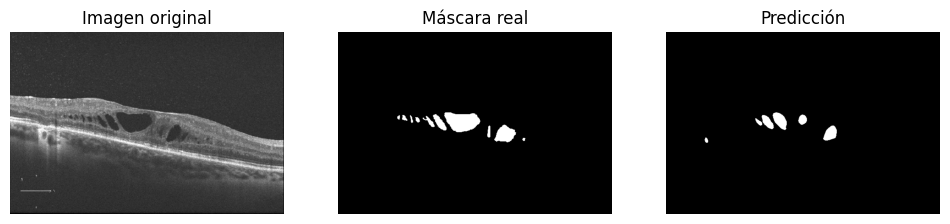

In [13]:
thresh = 0.9
# Mostrar ejemplos del conjunto de validación
num_samples = 8
model.eval()

with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        images = images.to(device)
        outputs = model(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(num_samples, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción")
            for a in ax:
                a.axis('off')
            plt.show()

        break  # solo una tanda de imágenes

## Mejoras Propuestas

### Sobre el modelo

Batch Normalization y Dropout

In [15]:
import torch.nn as nn

def double_conv(in_channels, out_channels, dropout_prob=0.0):
    layers = [
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if dropout_prob > 0.0:
        layers.append(nn.Dropout2d(p=dropout_prob))
    return nn.Sequential(*layers)

class UNet(nn.Module):
    def __init__(self, input_channels, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256, dropout_prob=0.3)
        self.dconv_down4 = double_conv(256, 512, dropout_prob=0.3)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256, dropout_prob=0.3)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

#### Entrenamiento mejoras

Device: cuda:0
[1/50] Train Loss: 1.0870 | Val Loss: 1.2662 | Time: 12.41s
  ↳ Modelo mejorado guardado
[2/50] Train Loss: 0.7344 | Val Loss: 1.2739 | Time: 12.84s
[3/50] Train Loss: 0.6207 | Val Loss: 1.3040 | Time: 12.72s
[4/50] Train Loss: 0.5750 | Val Loss: 1.3369 | Time: 12.34s
[5/50] Train Loss: 0.5461 | Val Loss: 1.3749 | Time: 12.0s
[6/50] Train Loss: 0.4793 | Val Loss: 1.4105 | Time: 11.93s
[7/50] Train Loss: 0.4666 | Val Loss: 1.4318 | Time: 12.04s
[8/50] Train Loss: 0.4289 | Val Loss: 1.2594 | Time: 12.22s
  ↳ Modelo mejorado guardado
[9/50] Train Loss: 0.4159 | Val Loss: 1.0117 | Time: 12.92s
  ↳ Modelo mejorado guardado
[10/50] Train Loss: 0.4122 | Val Loss: 0.6835 | Time: 12.87s
  ↳ Modelo mejorado guardado
[11/50] Train Loss: 0.4016 | Val Loss: 0.8033 | Time: 12.67s
[12/50] Train Loss: 0.3794 | Val Loss: 0.5565 | Time: 12.24s
  ↳ Modelo mejorado guardado
[13/50] Train Loss: 0.3800 | Val Loss: 0.4729 | Time: 12.26s
  ↳ Modelo mejorado guardado
[14/50] Train Loss: 0.3661 |

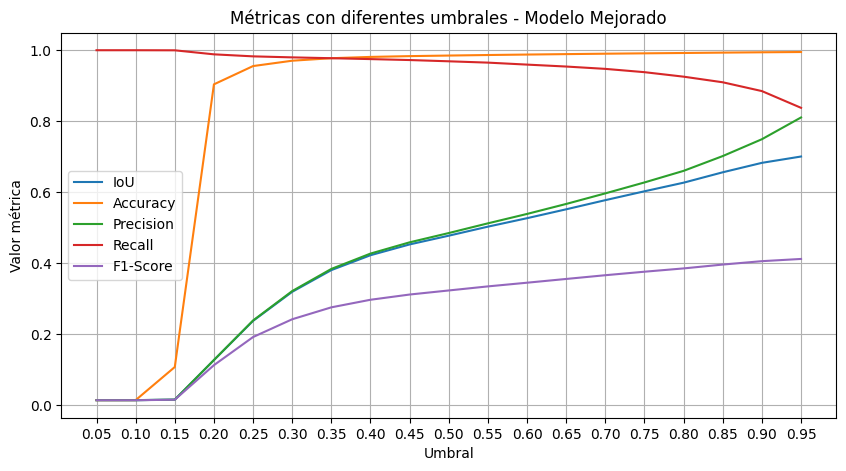

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import precision_score, recall_score, accuracy_score, jaccard_score
import numpy as np
import matplotlib.pyplot as plt

# Configuración
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Modelo mejorado
model_improved = UNet(input_channels=1, n_class=1).to(device)

# Función de pérdida y optimizador
pos_weight = torch.tensor([60.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_improved.parameters(), lr=1e-4)

# Entrenamiento
num_epochs = 50
best_val_loss = float('inf')
model_path_improved = "best_unet_model_improved.pth"

for epoch in range(num_epochs):
    start_time = time.time()
    model_improved.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model_improved(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Validación
    model_improved.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model_improved(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)

    epoch_time = round(time.time() - start_time, 2)
    print(f"[{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_improved.state_dict(), model_path_improved)
        print("  ↳ Modelo mejorado guardado")

# --------- EVALUACIÓN ---------

def get_binary_mask(output, threshold=0.5):
    return (torch.sigmoid(output) > threshold).float()

# Métricas para varios umbrales
model_improved.load_state_dict(torch.load(model_path_improved))
model_improved.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_improved(images)
            preds = get_binary_mask(outputs, threshold=thresh)
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = ((precision * recall)/(precision + recall))

    results[i] = [thresh, iou, acc, precision, recall, f1]

# --------- VISUALIZACIÓN ---------

iou_results  = results[:, 1]
acc_results  = results[:, 2]
prec_results = results[:, 3]
rec_results  = results[:, 4]
f1_results   = results[:, 5]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, iou_results, label="IoU")
plt.plot(thresholds, acc_results, label="Accuracy")
plt.plot(thresholds, prec_results, label="Precision")
plt.plot(thresholds, rec_results, label="Recall")
plt.plot(thresholds, f1_results, label="F1-Score")
plt.legend(loc="center left")
plt.title("Métricas con diferentes umbrales - Modelo Mejorado")
plt.xticks(thresholds)
plt.ylabel("Valor métrica")
plt.xlabel("Umbral")
plt.grid(True)
plt.show()


#### Métricas numéricas e imágenes resultantes de la mejora

In [17]:
import pandas as pd

# Mostrar los resultados como DataFrame
metrics_df = pd.DataFrame(results, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
pd.set_option("display.precision", 4)
print("Resumen de métricas por umbral:")
display(metrics_df)

Resumen de métricas por umbral:


Threshold     IoU  Accuracy  Precision  Recall  F1-Score
0        0.05  0.0142    0.0142     0.0142  1.0000    0.0140
1        0.10  0.0142    0.0142     0.0142  1.0000    0.0140
2        0.15  0.0156    0.1075     0.0156  0.9998    0.0154
3        0.20  0.1270    0.9039     0.1272  0.9884    0.1127
4        0.25  0.2376    0.9554     0.2386  0.9827    0.1920
5        0.30  0.3194    0.9704     0.3215  0.9799    0.2421
6        0.35  0.3805    0.9775     0.3839  0.9775    0.2756
7        0.40  0.4225    0.9811     0.4271  0.9750    0.2970
8        0.45  0.4529    0.9834     0.4588  0.9723    0.3117
9        0.50  0.4775    0.9850     0.4850  0.9688    0.3232
10       0.55  0.5030    0.9865     0.5123  0.9651    0.3346
11       0.60  0.5268    0.9878     0.5388  0.9595    0.3450
12       0.65  0.5518    0.9890     0.5669  0.9540    0.3556
13       0.70  0.5776    0.9902     0.5967  0.9474    0.3661
14       0.75  0.6026    0.9912     0.6275  0.9382    0.3760
15       0.80  0.6268    0.9922     0.6602  0.9255    0.3853
16       0.85  0.6561    0.9933     0.7019  0.9097    0.3962
17       0.90  0.6827    0.9942     0.7493  0.8849    0.4057
18       0.95  0.7006    0.9949     0.8106  0.8377    0.4120

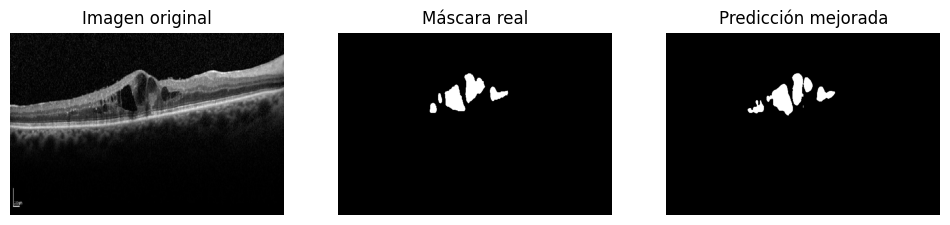

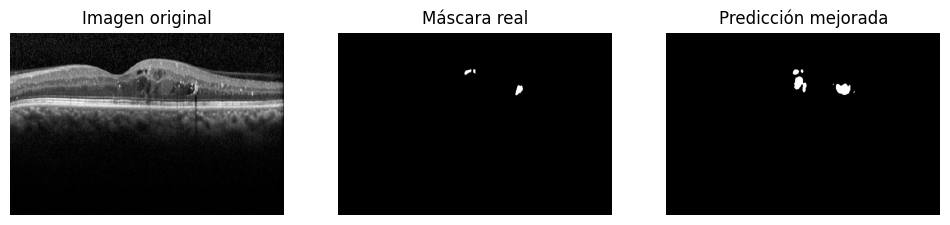

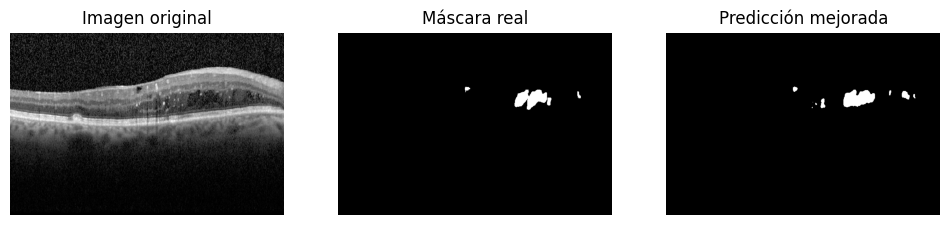

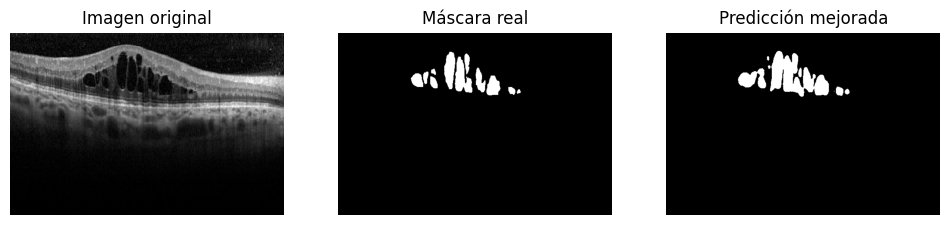

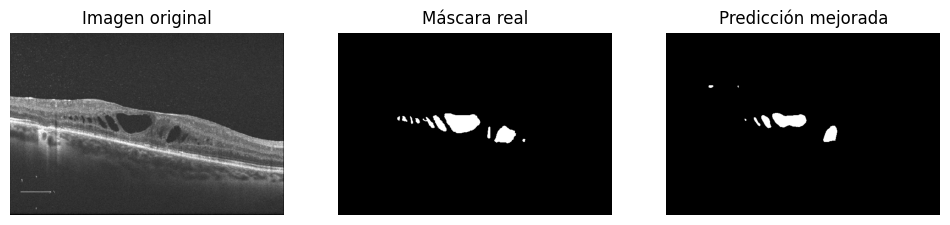

In [18]:
# Visualización de resultados del modelo mejorado
thresh = 0.9  # puedes cambiar este umbral si deseas
num_samples = 8
model_improved.eval()

with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        images = images.to(device)
        outputs = model_improved(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(num_samples, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción mejorada")
            for a in ax:
                a.axis('off')
            plt.show()

        break  # solo una tanda de imágenes


### Preprocesamiento y DataAugmentation

In [19]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# Transformación con data augmentation (solo para entrenamiento)
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 624), interpolation=InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # pequeños desplazamientos
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor()
])

# Validación sin augmentación
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 624), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Redefinir datasets
train_dataset = OCTSubsetDataset(train_imgs, image_path, mask_path, transform=train_transform)
val_dataset = OCTSubsetDataset(val_imgs, image_path, mask_path, transform=val_transform)

# Redefinir dataloaders (igual que antes)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


#### Entrenamiento y evaluación para Data Augmentation

In [20]:
# Redefinir el modelo base (sin mejoras de arquitectura)
model_augmented = UNet(input_channels=1, n_class=1).to(device)

# Pérdida y optimizador
pos_weight = torch.tensor([60.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_augmented.parameters(), lr=1e-4)

# Entrenamiento
num_epochs = 50
best_val_loss = float('inf')
model_path_augmented = "best_unet_model_augmented.pth"

for epoch in range(num_epochs):
    start_time = time.time()
    model_augmented.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model_augmented(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    model_augmented.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model_augmented(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)

    epoch_time = round(time.time() - start_time, 2)
    print(f"[{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_augmented.state_dict(), model_path_augmented)
        print("  ↳ Modelo con data augmentation guardado")


[1/50] Train Loss: 1.1147 | Val Loss: 1.2853 | Time: 12.62s
  ↳ Modelo con augmentación guardado
[2/50] Train Loss: 0.9201 | Val Loss: 1.2836 | Time: 13.65s
  ↳ Modelo con augmentación guardado
[3/50] Train Loss: 0.8297 | Val Loss: 1.2772 | Time: 15.73s
  ↳ Modelo con augmentación guardado
[4/50] Train Loss: 0.7705 | Val Loss: 1.2716 | Time: 15.06s
  ↳ Modelo con augmentación guardado
[5/50] Train Loss: 0.6793 | Val Loss: 1.2795 | Time: 13.15s
[6/50] Train Loss: 0.6557 | Val Loss: 1.2916 | Time: 13.36s
[7/50] Train Loss: 0.5974 | Val Loss: 1.3156 | Time: 12.71s
[8/50] Train Loss: 0.5810 | Val Loss: 1.1954 | Time: 12.83s
  ↳ Modelo con augmentación guardado
[9/50] Train Loss: 0.5985 | Val Loss: 0.8389 | Time: 13.4s
  ↳ Modelo con augmentación guardado
[10/50] Train Loss: 0.5609 | Val Loss: 0.9145 | Time: 12.84s
[11/50] Train Loss: 0.5417 | Val Loss: 0.6424 | Time: 12.74s
  ↳ Modelo con augmentación guardado
[12/50] Train Loss: 0.5307 | Val Loss: 0.5743 | Time: 12.73s
  ↳ Modelo con augm

#### Métricas y gráfica

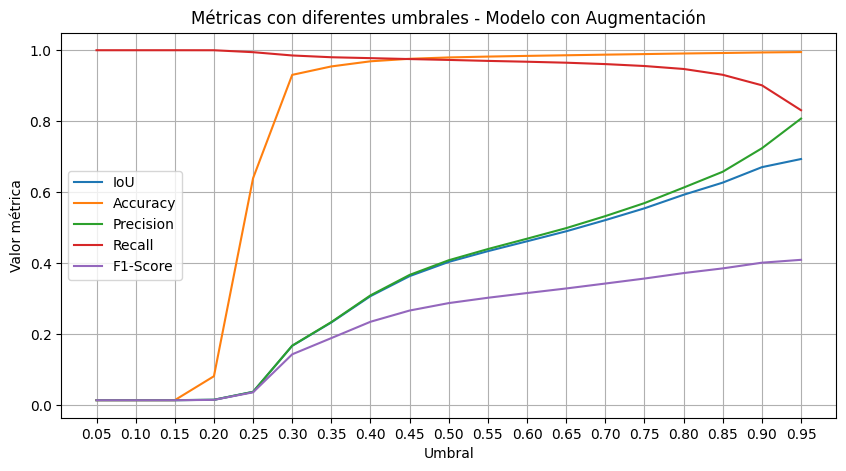

In [21]:
# Evaluar modelo entrenado con augmentación
model_augmented.load_state_dict(torch.load(model_path_augmented))
model_augmented.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results_aug = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_augmented(images)
            preds = get_binary_mask(outputs, threshold=thresh)
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = (precision * recall) / (precision + recall)

    results_aug[i] = [thresh, iou, acc, precision, recall, f1]

# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(thresholds, results_aug[:, 1], label="IoU")
plt.plot(thresholds, results_aug[:, 2], label="Accuracy")
plt.plot(thresholds, results_aug[:, 3], label="Precision")
plt.plot(thresholds, results_aug[:, 4], label="Recall")
plt.plot(thresholds, results_aug[:, 5], label="F1-Score")
plt.legend(loc="center left")
plt.title("Métricas con diferentes umbrales - Modelo con Augmentación")
plt.xticks(thresholds)
plt.ylabel("Valor métrica")
plt.xlabel("Umbral")
plt.grid(True)
plt.show()

#### Métricas numéricas y predicciones nuevas

In [22]:
# Mostrar tabla de métricas
import pandas as pd

metrics_aug_df = pd.DataFrame(results_aug, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
print("Resumen de métricas por umbral:")
display(metrics_aug_df)

Resumen de métricas por umbral:


Threshold     IoU  Accuracy  Precision  Recall  F1-Score
0        0.05  0.0142    0.0142     0.0142  1.0000    0.0140
1        0.10  0.0142    0.0142     0.0142  1.0000    0.0140
2        0.15  0.0142    0.0142     0.0142  1.0000    0.0140
3        0.20  0.0152    0.0816     0.0152  0.9999    0.0149
4        0.25  0.0376    0.6394     0.0376  0.9945    0.0362
5        0.30  0.1673    0.9306     0.1677  0.9852    0.1433
6        0.35  0.2331    0.9544     0.2342  0.9802    0.1890
7        0.40  0.3072    0.9688     0.3094  0.9777    0.2350
8        0.45  0.3636    0.9758     0.3670  0.9751    0.2667
9        0.50  0.4037    0.9797     0.4083  0.9726    0.2876
10       0.55  0.4339    0.9821     0.4399  0.9699    0.3026
11       0.60  0.4618    0.9840     0.4690  0.9676    0.3159
12       0.65  0.4899    0.9858     0.4988  0.9648    0.3288
13       0.70  0.5214    0.9875     0.5326  0.9609    0.3427
14       0.75  0.5546    0.9891     0.5693  0.9555    0.3568
15       0.80  0.5928    0.9908     0.6130  0.9472    0.3722
16       0.85  0.6270    0.9922     0.6577  0.9308    0.3854
17       0.90  0.6706    0.9937     0.7238  0.9012    0.4014
18       0.95  0.6935    0.9948     0.8074  0.8309    0.4095

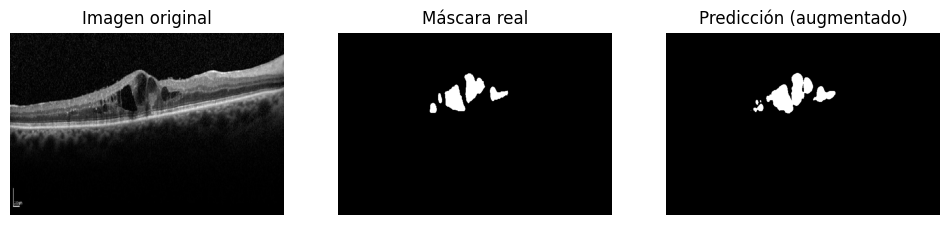

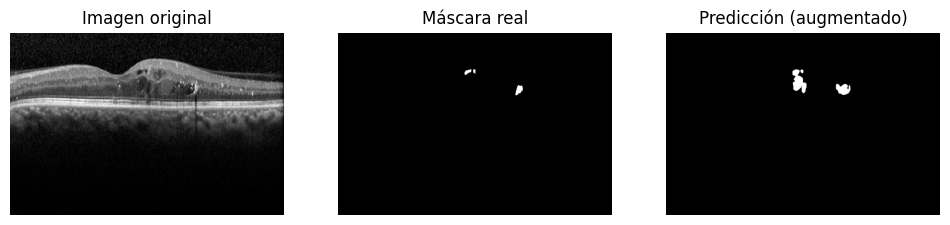

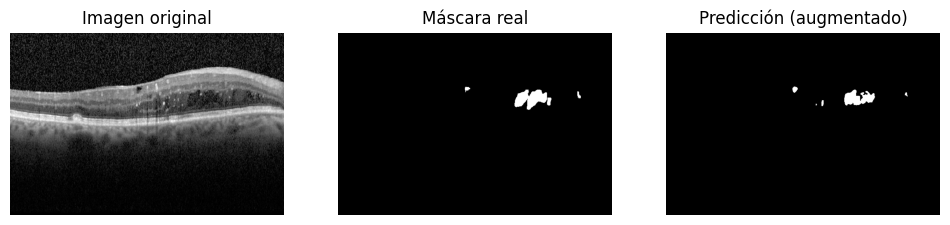

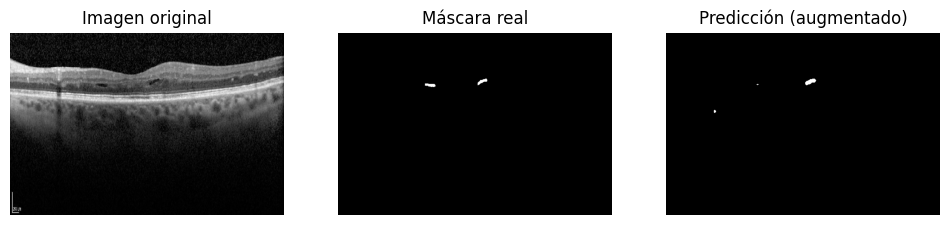

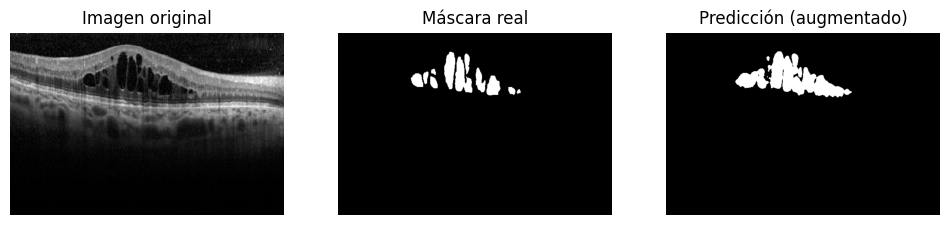

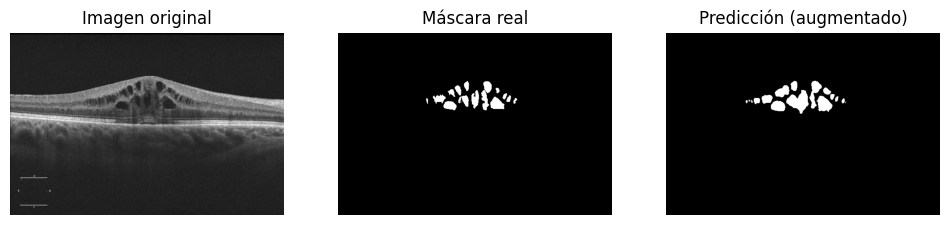

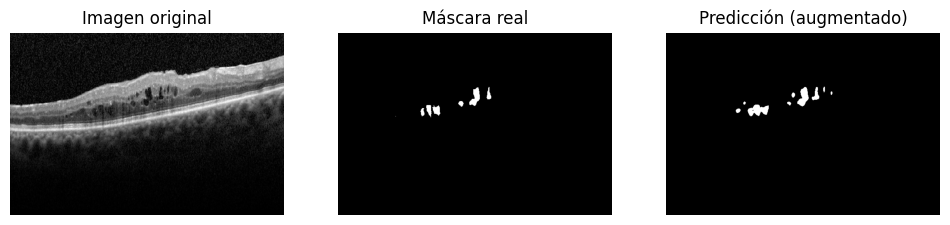

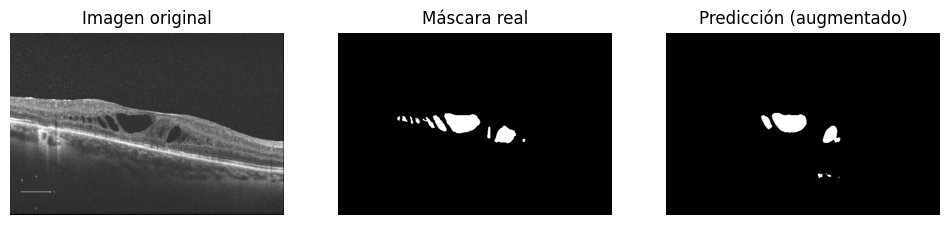

In [23]:
# Visualizar predicciones del modelo entrenado con augmentación
thresh = 0.9
model_augmented.eval()

with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        images = images.to(device)
        outputs = model_augmented(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(8, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción (augmentado)")
            for a in ax:
                a.axis('off')
            plt.show()

        break

## Mejora función de pérdida para regiones desbalanceadas

In [24]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)
        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1 - dice

# BCE + Dice
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, pos_weight=None):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss


### Con arquitectura base

In [25]:
# Modelo base
model_bce_dice = UNet(input_channels=1, n_class=1).to(device)

# Nueva función de pérdida: BCE + Dice
criterion = BCEDiceLoss(bce_weight=0.5, pos_weight=torch.tensor([60.0]).to(device))
optimizer = optim.Adam(model_bce_dice.parameters(), lr=1e-4)

model_path_bce_dice = "best_unet_bce_dice.pth"
best_val_loss = float('inf')

# Entrenamiento
for epoch in range(50):
    model_bce_dice.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_bce_dice(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    model_bce_dice.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_bce_dice(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"[{epoch+1}/50] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_bce_dice.state_dict(), model_path_bce_dice)
        print(" ↳ Modelo BCE+Dice (base) guardado")


[1/50] Train Loss: 1.0453 | Val Loss: 1.1205
 ↳ Modelo BCE+Dice (base) guardado
[2/50] Train Loss: 0.8546 | Val Loss: 1.1206
[3/50] Train Loss: 0.7797 | Val Loss: 1.1315
[4/50] Train Loss: 0.7367 | Val Loss: 1.1439
[5/50] Train Loss: 0.7387 | Val Loss: 1.1464
[6/50] Train Loss: 0.7307 | Val Loss: 1.1327
[7/50] Train Loss: 0.6778 | Val Loss: 1.1275
[8/50] Train Loss: 0.6715 | Val Loss: 1.0284
 ↳ Modelo BCE+Dice (base) guardado
[9/50] Train Loss: 0.6674 | Val Loss: 0.9193
 ↳ Modelo BCE+Dice (base) guardado
[10/50] Train Loss: 0.6408 | Val Loss: 0.8037
 ↳ Modelo BCE+Dice (base) guardado
[11/50] Train Loss: 0.6431 | Val Loss: 0.8140
[12/50] Train Loss: 0.6231 | Val Loss: 0.7888
 ↳ Modelo BCE+Dice (base) guardado
[13/50] Train Loss: 0.6189 | Val Loss: 0.6388
 ↳ Modelo BCE+Dice (base) guardado
[14/50] Train Loss: 0.6232 | Val Loss: 0.6371
 ↳ Modelo BCE+Dice (base) guardado
[15/50] Train Loss: 0.6289 | Val Loss: 0.7010
[16/50] Train Loss: 0.6124 | Val Loss: 0.6061
 ↳ Modelo BCE+Dice (base) gu

### Evaluación y métricas

In [26]:
# Evaluación del modelo base con BCE+Dice
model_bce_dice.load_state_dict(torch.load("best_unet_bce_dice.pth"))
model_bce_dice.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results_bce_dice = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_bce_dice(images)
            preds = get_binary_mask(outputs, threshold=thresh)
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = (precision * recall) / (precision + recall)

    results_bce_dice[i] = [thresh, iou, acc, precision, recall, f1]


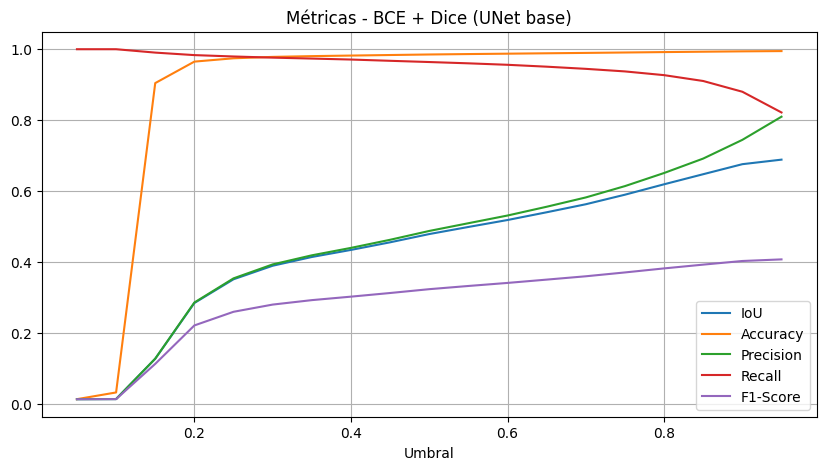

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, results_bce_dice[:, 1], label="IoU")
plt.plot(thresholds, results_bce_dice[:, 2], label="Accuracy")
plt.plot(thresholds, results_bce_dice[:, 3], label="Precision")
plt.plot(thresholds, results_bce_dice[:, 4], label="Recall")
plt.plot(thresholds, results_bce_dice[:, 5], label="F1-Score")
plt.legend()
plt.title("Métricas - BCE + Dice (UNet base)")
plt.xlabel("Umbral")
plt.grid(True)
plt.show()


In [28]:
metrics_bce_dice_df = pd.DataFrame(results_bce_dice, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
print("Resumen de métricas por umbral:")
display(metrics_bce_dice_df)


Resumen de métricas por umbral:


Threshold     IoU  Accuracy  Precision  Recall  F1-Score
0        0.05  0.0142    0.0142     0.0142  1.0000    0.0140
1        0.10  0.0144    0.0330     0.0144  1.0000    0.0142
2        0.15  0.1281    0.9046     0.1282  0.9905    0.1135
3        0.20  0.2851    0.9651     0.2864  0.9834    0.2218
4        0.25  0.3519    0.9745     0.3545  0.9796    0.2603
5        0.30  0.3900    0.9784     0.3937  0.9763    0.2806
6        0.35  0.4146    0.9805     0.4193  0.9737    0.2931
7        0.40  0.4346    0.9821     0.4403  0.9709    0.3029
8        0.45  0.4560    0.9837     0.4631  0.9674    0.3132
9        0.50  0.4792    0.9852     0.4880  0.9639    0.3240
10       0.55  0.4992    0.9864     0.5098  0.9603    0.3330
11       0.60  0.5188    0.9874     0.5315  0.9561    0.3416
12       0.65  0.5406    0.9886     0.5562  0.9508    0.3509
13       0.70  0.5632    0.9896     0.5824  0.9447    0.3603
14       0.75  0.5902    0.9908     0.6143  0.9375    0.3711
15       0.80  0.6195    0.9919     0.6513  0.9270    0.3825
16       0.85  0.6479    0.9930     0.6920  0.9105    0.3932
17       0.90  0.6761    0.9940     0.7447  0.8802    0.4034
18       0.95  0.6889    0.9947     0.8099  0.8218    0.4079

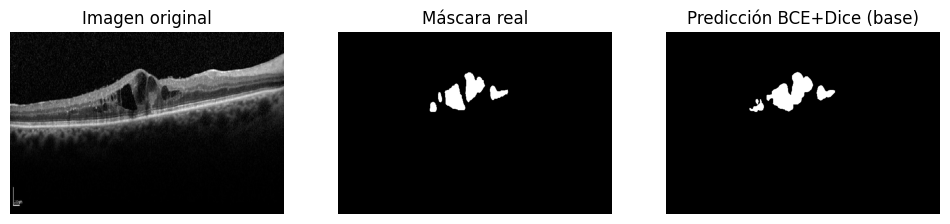

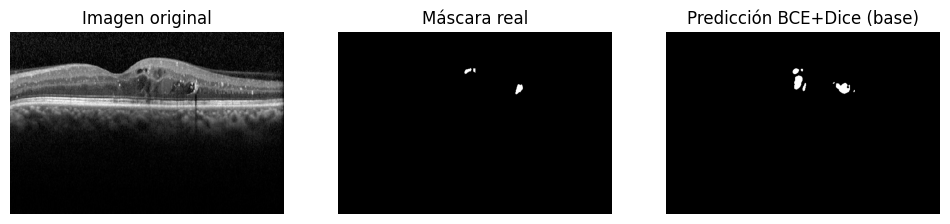

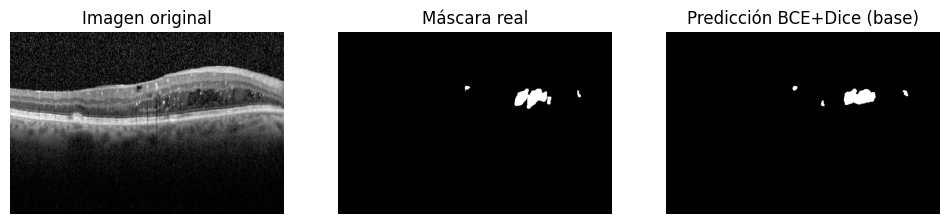

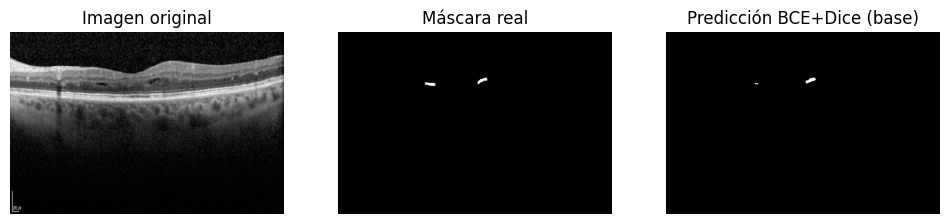

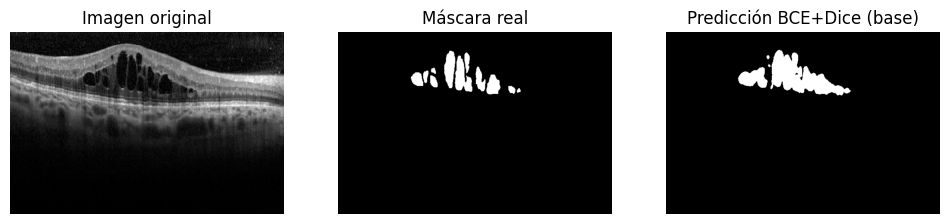

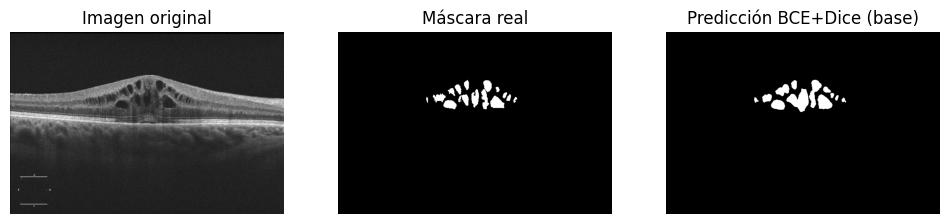

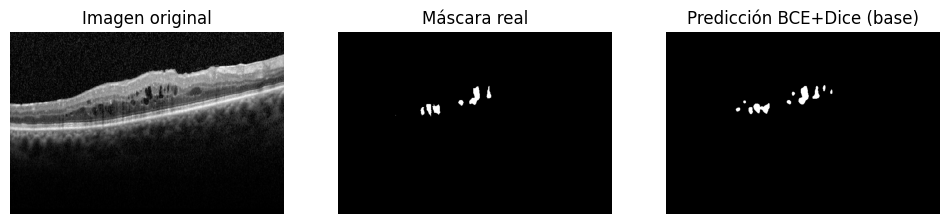

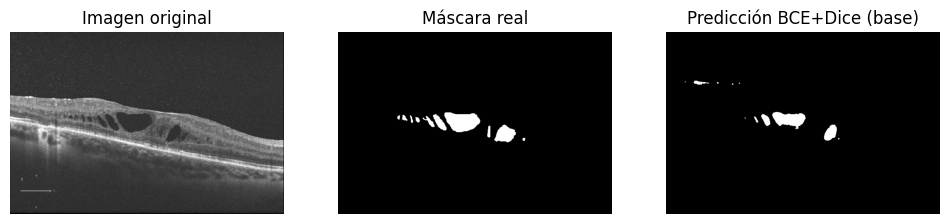

In [29]:
thresh = 0.9
model_bce_dice.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model_bce_dice(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(8, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción BCE+Dice (base)")
            for a in ax: a.axis('off')
            plt.show()
        break


### Con arquitectura mejorada

In [30]:
# Modelo mejorado
model_full = UNet(input_channels=1, n_class=1).to(device)

# BCE + Dice como pérdida
criterion = BCEDiceLoss(bce_weight=0.5, pos_weight=torch.tensor([60.0]).to(device))
optimizer = optim.Adam(model_full.parameters(), lr=1e-4)

model_path_full = "best_unet_full_combo.pth"
best_val_loss = float('inf')

# Entrenamiento
for epoch in range(50):
    model_full.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_full(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    model_full.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_full(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"[{epoch+1}/50] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_full.state_dict(), model_path_full)
        print(" ↳ Modelo BCE+Dice (mejorado) guardado")

[1/50] Train Loss: 1.0598 | Val Loss: 1.1201
 ↳ Modelo BCE+Dice (mejorado) guardado
[2/50] Train Loss: 0.8955 | Val Loss: 1.1187
 ↳ Modelo BCE+Dice (mejorado) guardado
[3/50] Train Loss: 0.8273 | Val Loss: 1.1186
 ↳ Modelo BCE+Dice (mejorado) guardado
[4/50] Train Loss: 0.7995 | Val Loss: 1.1213
[5/50] Train Loss: 0.7659 | Val Loss: 1.1476
[6/50] Train Loss: 0.7331 | Val Loss: 1.1879
[7/50] Train Loss: 0.7385 | Val Loss: 1.1294
[8/50] Train Loss: 0.7204 | Val Loss: 0.9987
 ↳ Modelo BCE+Dice (mejorado) guardado
[9/50] Train Loss: 0.6968 | Val Loss: 0.8059
 ↳ Modelo BCE+Dice (mejorado) guardado
[10/50] Train Loss: 0.7036 | Val Loss: 0.7556
 ↳ Modelo BCE+Dice (mejorado) guardado
[11/50] Train Loss: 0.6930 | Val Loss: 0.6873
 ↳ Modelo BCE+Dice (mejorado) guardado
[12/50] Train Loss: 0.6843 | Val Loss: 0.6442
 ↳ Modelo BCE+Dice (mejorado) guardado
[13/50] Train Loss: 0.6863 | Val Loss: 0.6846
[14/50] Train Loss: 0.6630 | Val Loss: 0.6648
[15/50] Train Loss: 0.6658 | Val Loss: 0.6528
[16/50]

### Evaluación y métricas

In [31]:
# Evaluación del modelo mejorado con BCE+Dice
model_full.load_state_dict(torch.load("best_unet_full_combo.pth"))
model_full.eval()

gap = 0.05
thresholds = np.arange(gap, 1, gap)
results_full_combo = np.zeros((len(thresholds), 6))

for i, thresh in enumerate(thresholds):
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_full(images)
            preds = get_binary_mask(outputs, threshold=thresh)
            all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
            all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
    acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = (precision * recall) / (precision + recall)

    results_full_combo[i] = [thresh, iou, acc, precision, recall, f1]


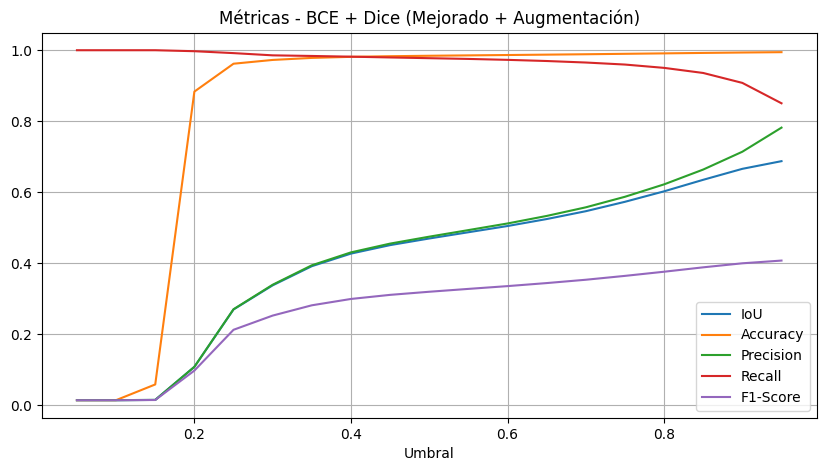

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, results_full_combo[:, 1], label="IoU")
plt.plot(thresholds, results_full_combo[:, 2], label="Accuracy")
plt.plot(thresholds, results_full_combo[:, 3], label="Precision")
plt.plot(thresholds, results_full_combo[:, 4], label="Recall")
plt.plot(thresholds, results_full_combo[:, 5], label="F1-Score")
plt.legend()
plt.title("Métricas - BCE + Dice (Mejorado + Augmentación)")
plt.xlabel("Umbral")
plt.grid(True)
plt.show()


In [33]:
metrics_full_df = pd.DataFrame(results_full_combo, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
print("Resumen de métricas por umbral:")
display(metrics_full_df)


Resumen de métricas por umbral:


Threshold     IoU  Accuracy  Precision  Recall  F1-Score
0        0.05  0.0142    0.0142     0.0142  1.0000    0.0140
1        0.10  0.0142    0.0142     0.0142  1.0000    0.0140
2        0.15  0.0148    0.0584     0.0148  1.0000    0.0146
3        0.20  0.1080    0.8834     0.1080  0.9972    0.0975
4        0.25  0.2696    0.9620     0.2702  0.9918    0.2124
5        0.30  0.3376    0.9726     0.3393  0.9856    0.2524
6        0.35  0.3915    0.9784     0.3941  0.9838    0.2814
7        0.40  0.4270    0.9814     0.4304  0.9818    0.2992
8        0.45  0.4509    0.9831     0.4552  0.9796    0.3108
9        0.50  0.4696    0.9844     0.4747  0.9776    0.3195
10       0.55  0.4872    0.9855     0.4932  0.9755    0.3276
11       0.60  0.5047    0.9865     0.5119  0.9729    0.3354
12       0.65  0.5243    0.9876     0.5331  0.9696    0.3440
13       0.70  0.5465    0.9887     0.5574  0.9654    0.3534
14       0.75  0.5730    0.9899     0.5871  0.9596    0.3643
15       0.80  0.6025    0.9911     0.6221  0.9503    0.3760
16       0.85  0.6350    0.9924     0.6638  0.9359    0.3884
17       0.90  0.6658    0.9936     0.7141  0.9079    0.3997
18       0.95  0.6874    0.9945     0.7819  0.8505    0.4074

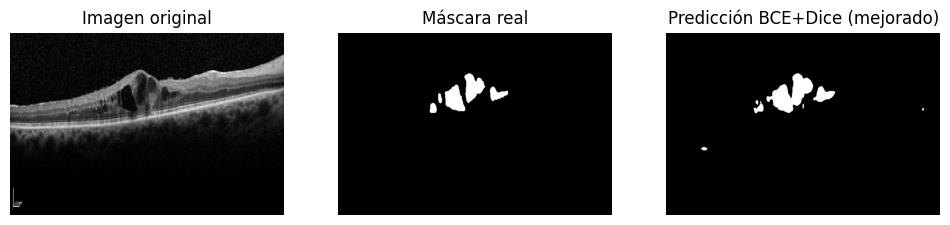

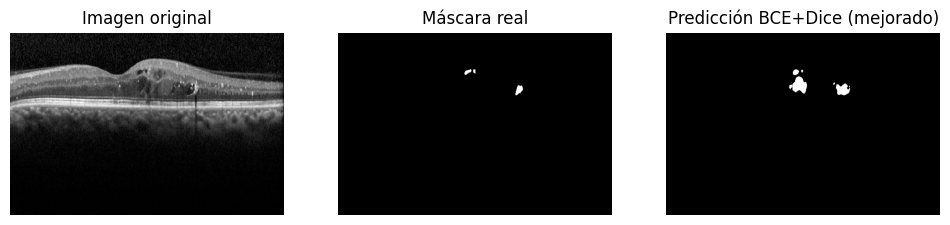

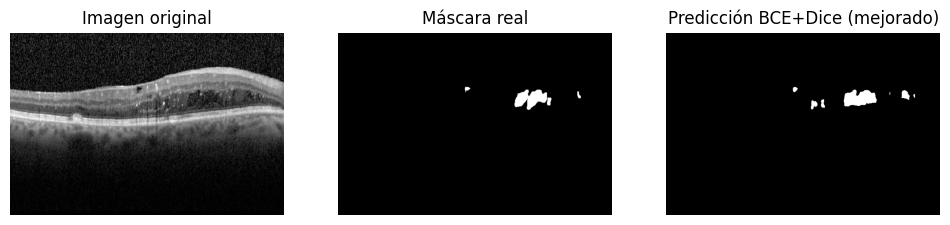

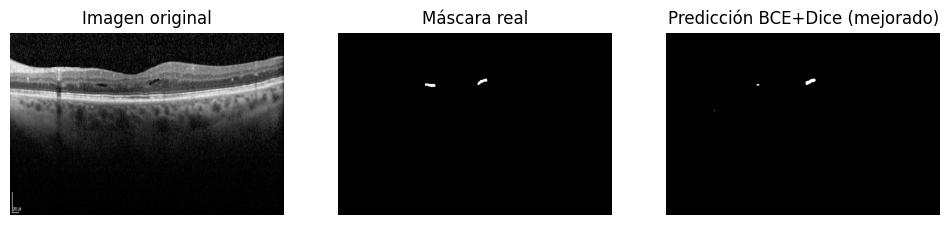

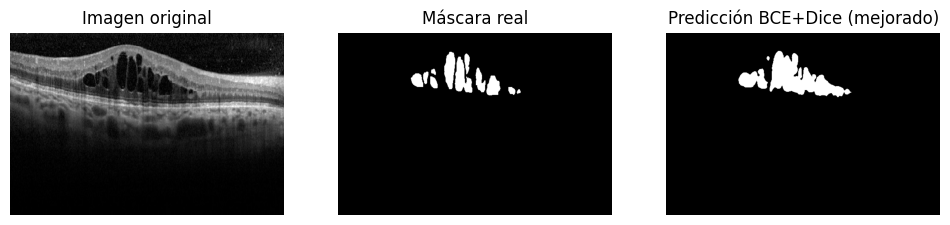

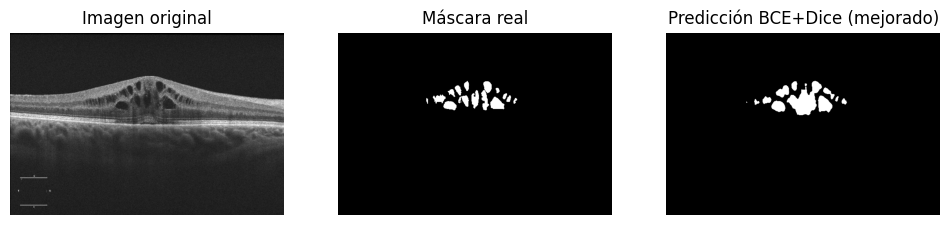

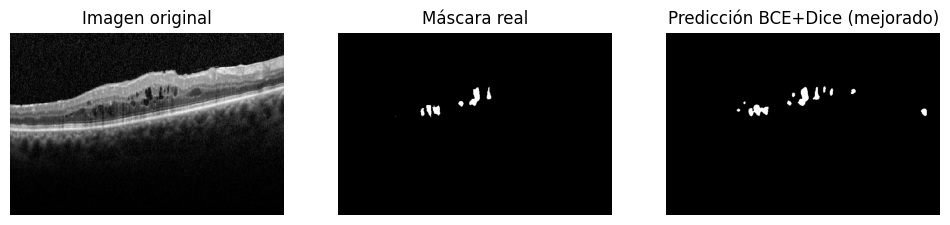

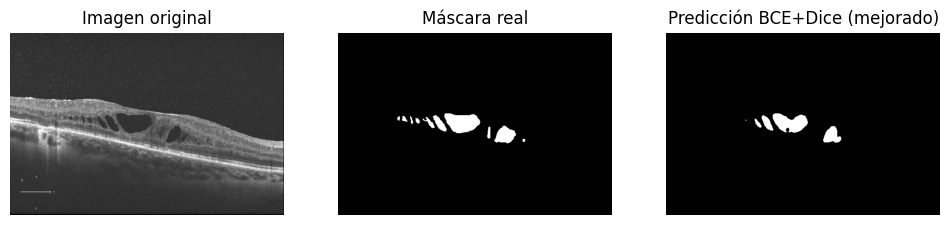

In [34]:
thresh = 0.9
model_full.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model_full(images)
        preds = get_binary_mask(outputs, threshold=thresh).cpu()

        for j in range(min(8, images.size(0))):
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
            ax[0].set_title("Imagen original")
            ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Máscara real")
            ax[2].imshow(preds[j].squeeze(), cmap="gray")
            ax[2].set_title("Predicción BCE+Dice (mejorado)")
            for a in ax: a.axis('off')
            plt.show()
        break
